### Import Packages

In [44]:
import pandas as pd
import logging 
import os
import time
import requests 
import tiktoken
import ray
import numpy as np
import json
import pickle
import openai

from math import ceil
from numba import jit
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# In order for ray to work, make sure you uninstall pydantic and reinstall this: pip install "pydantic<2"
from class_data.data import Data
from utils.system import *

# Set OPENAI KEY
os.environ["OPENAI_API_KEY"] = json.load(open(get_config() / 'api.json'))['openai_api_key']

import warnings
warnings.filterwarnings('ignore')

### CC

In [45]:
cc = pd.read_csv(get_data() / 'cc_article' / 'cc_aapl.csv')

In [46]:
cc_substrings = ['corporate conference call', 'earnings call', 'earnings conference call', 'conference call']
cc['cc_or_not'] = cc['Headline'].str.lower().str.contains('|'.join(cc_substrings))
cc = cc.loc[cc['cc_or_not'] == True]

In [47]:
ceo_substrings = ['ceo']
cc['ceo_or_not'] = cc['name'].str.lower().str.contains('|'.join(ceo_substrings))

In [48]:
@jit
def fast_word_count(texts):
    counts = np.zeros(len(texts), dtype=np.int32)
    for i, text in enumerate(texts):
        counts[i] = len(text.split())
    return counts

cc['word_count'] = fast_word_count(cc['body'].values)

word count mean: 79.03064787275314
word count std: 207.17058748714615
word count max: 2912


<Axes: >

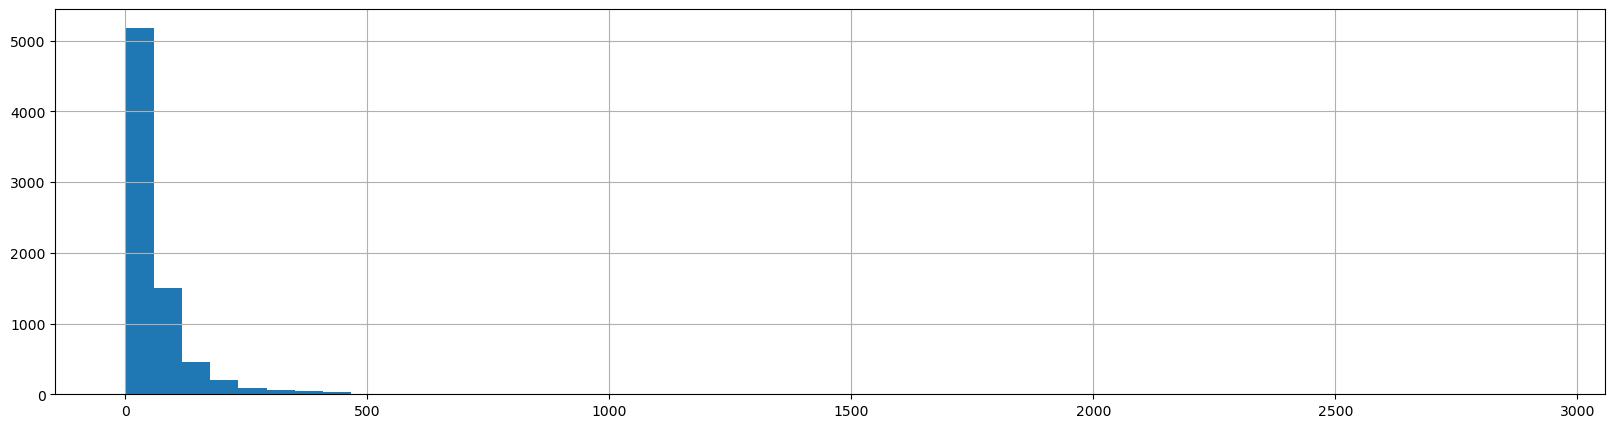

In [49]:
print("word count mean:", cc.word_count.mean())
print("word count std:", cc.word_count.std())
print("word count max:", cc.word_count.max())
cc.word_count.hist(bins=50, figsize=(20,5))

In [50]:
word_count = 80
cc = cc.loc[cc.word_count >= word_count]

In [51]:
print("word count mean:", cc.word_count.mean())
print("word count std:", cc.word_count.std())
print("word count max:", cc.word_count.max())

word count mean: 249.46871628910463
word count std: 373.11200114663455
word count max: 2912


In [52]:
cc['date'] = pd.to_datetime(cc['date'])

In [53]:
cc = cc.set_index(['fid', 'date'])

### Parallelized: Get embeddings (per article)

In [54]:
@ray.remote
def get_embedding_article(article_text, model):
    try:
        embedding = openai.embeddings.create(input=[article_text.replace("\n", " ")], model=model).data[0].embedding
        return embedding
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        return None

def process_articles_in_batches(output_folder, file_prefix, df, column_name, model, batch_size, delay_per_batch):
    num_batches = np.ceil(len(df) / batch_size)
    times = []
    
    for i in range(int(num_batches)):
        start_time = time.time()
        
        # Check if the batch has already been processed
        # save_path = get_format_data() / 'openai' / f'cc_emb_textemb3small_{i}.parquet.brotli'
        save_path = output_folder / f'{file_prefix}_{i}.parquet.brotli'
        if save_path.exists():
            print(f"Skipping batch {i + 1}/{int(num_batches)} (already processed)")
            continue

        # Get batch
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(df))
        batch = df[column_name][start_index:end_index]
        
        # Start asynchronous tasks for the batch
        futures = [get_embedding_article.remote(text, model) for text in batch]
        embeddings = ray.get(futures)

        # Save Batch
        print(f"Saving progress to {save_path}")
        all_indices = df.index[start_index:end_index]
        temp_df = pd.DataFrame({'ada_embedding': embeddings}, index=all_indices)
        temp_df.to_parquet(save_path, compression='brotli')
        print("Progress saved")

        # Delay between batches if specified
        if delay_per_batch > 0:
            time.sleep(delay_per_batch)
        
        # Time taken for the batch
        end_time = time.time()
        batch_time = end_time - start_time
        times.append(batch_time)
        
        # Calculate and print the time taken for the batch
        print(f"Batch {i + 1}/{int(num_batches)} processed in {batch_time:.2f} seconds")
        
        # Calculate and print estimated time to finish
        avg_time_per_batch = np.mean(times)
        batches_left = int(num_batches) - (i + 1)
        estimated_time_left = avg_time_per_batch * batches_left
        hours, rem = divmod(estimated_time_left, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Estimated time to finish: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        
    return None

In [55]:
# Parameters
output_folder = get_format_data() / 'test'
file_prefix = f'cc_emb_all_{word_count}_textemb3small'
model_name = 'text-embedding-3-small'
batch_size = 500
delay_per_batch = 0

In [56]:
# Process articles in batches
ray.init(num_cpus=16, ignore_reinit_error=True)

start_time = time.time()
process_articles_in_batches(output_folder=output_folder, file_prefix=file_prefix, df=cc[['body']], column_name='body', model=model_name, batch_size=batch_size, delay_per_batch=delay_per_batch)
elapsed_time = time.time() - start_time
print(f"Total time to get all embeddings: {round(elapsed_time)} seconds")

# Shutdown Ray
ray.shutdown()

2024-04-24 23:43:52,177	INFO worker.py:1507 -- Calling ray.init() again after it has already been called.


Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\test\cc_emb_all_80_textemb3small_0.parquet.brotli
Progress saved
Batch 1/4 processed in 12.17 seconds
Estimated time to finish: 0h 0m 36.50s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\test\cc_emb_all_80_textemb3small_1.parquet.brotli
Progress saved
Batch 2/4 processed in 7.28 seconds
Estimated time to finish: 0h 0m 19.44s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\test\cc_emb_all_80_textemb3small_2.parquet.brotli
Progress saved
Batch 3/4 processed in 8.00 seconds
Estimated time to finish: 0h 0m 9.15s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\test\cc_emb_all_80_textemb3small_3.parquet.brotli
Progress saved
Batch 4/4 processed in 5.92 seconds
Estimated time to finish: 0h 0m 0.00s
Total time to get all embeddings: 33 seconds


### Query

In [57]:
def get_emb(query):
    return np.array(openai.embeddings.create(input=[query.replace("\n", " ")], model='text-embedding-3-small').data[0].embedding).reshape(1, -1)

In [58]:
# Load openai embeddings
cc_emb = Data(folder_path=get_format_data() / 'test', file_pattern=f'{file_prefix}_*')
cc_emb = cc_emb.concat_files()

Loading Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 52.62it/s]


In [59]:
query = "Risk, Uncertainty, Politics, Policy, Government, Regulation, Stability, Election, Legislation, Economy, Political risk, Policy uncertainty, Government regulation, Economic policy, Legislative changes, Risk management, Market stability, Political stability, Regulatory framework, Economic instability, Level of uncertainty, Impact of regulation, Government policy changes, Political risk assessment, Economic policy uncertainty, Long term stability, Risk assessment process, Political instability risk, Regulatory compliance issues, Political climate change"
query_emb = get_emb(query)
score = cosine_similarity(query_emb, np.stack(cc_emb['ada_embedding'].values))[0]

In [60]:
score = pd.DataFrame(score, index=cc_emb.index, columns=['score'])

In [61]:
# Get threshold p_val
p_val = 0.10
scores = np.array(score['score'])
percentile = 100 * (1 - p_val)
threshold = np.percentile(scores, percentile)
relu_score = np.maximum(0, score['score'] - threshold)
relu_score = relu_score.to_frame('score')

In [62]:
relu_score['body'] = cc['body']

In [63]:
mask = relu_score['score'] == relu_score.groupby('date')['score'].transform('max')
max_article = relu_score[mask]

<Axes: xlabel='date'>

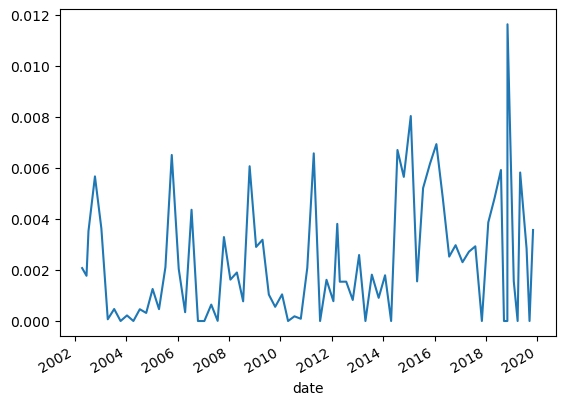

In [64]:
mean = relu_score.groupby('date')['score'].mean()
mean = mean.sort_index()
mean.plot()

In [65]:
aapl_risk = mean.to_frame()

In [66]:
# Function to convert 'YYYY-MM-DD' to 'YYYYqQ'
def date_to_quarter(date):
    year = date.year  
    quarter = (date.month - 1) // 3 + 1 
    return f'{year}q{quarter}'

aapl_risk.index = aapl_risk.index.map(date_to_quarter)

In [67]:
# Aggregrate duplicate quarters
aapl_risk = aapl_risk.groupby(aapl_risk.index)['score'].mean().to_frame('score')

### Read in Firm-Level Risk

In [68]:
# Firm-Level Risk
all_risk = pd.read_csv(get_data() / 'firmquarter_2022q1.csv', delimiter='\t', engine='python')

In [69]:
# Set index
all_risk = all_risk.set_index(['gvkey', 'date'])

In [70]:
all_risk.columns

Index(['PRisk', 'NPRisk', 'Risk', 'PSentiment', 'NPSentiment', 'Sentiment',
       'PRiskT_economic', 'PRiskT_environment', 'PRiskT_trade',
       'PRiskT_institutions', 'PRiskT_health', 'PRiskT_security', 'PRiskT_tax',
       'PRiskT_technology', 'company_name', 'hqcountrycode', 'isin', 'cusip',
       'ticker', 'date_earningscall', 'Covid_Exposure', 'Covid_Neg_Sentiment',
       'Covid_Pos_Sentiment', 'Covid_Net_Sentiment', 'Covid_Risk',
       'SARS_Exposure', 'H1N1_Exposure', 'Zika_Exposure', 'Ebola_Exposure',
       'Brexit_Exposure', 'Brexit_Neg_Sentiment', 'Brexit_Pos_Sentiment',
       'Brexit_Net_Sentiment', 'Brexit_Risk'],
      dtype='object')

In [71]:
# Political Risk
firm_risk = all_risk[['PRisk']]

In [72]:
# Link Data
link = pd.read_parquet(r'C:\Jonathan\QuantResearch\AlgoTradingModels\algofacto\trade_live\data_parquet\data_link.parquet.brotli')
link.loc[link.ticker == 'AAPL']

,gvkey,conm,ticker,cusip,cik,sic,naics,linkprim,linktype,liid,permno,lpermco,timeLinkStart_d,timeLinkEnd_d
722,001690,APPLE INC,AAPL,037833100,0000320193,3663,334220,P,LU,01,14593,7.0,1980-12-12,2024-04-08


### Compare

In [73]:
# Get AAPL
aapl_risk_off = firm_risk.loc[firm_risk.index.get_level_values('gvkey').isin([1690])]
aapl_risk_off = aapl_risk_off.reset_index(level=0, drop=True)

In [74]:
compare = aapl_risk.join(aapl_risk_off)

In [75]:
scaler = MinMaxScaler()
columns_to_scale = compare.columns
compare[columns_to_scale] = scaler.fit_transform(compare[columns_to_scale])

Correlation: 0.3443021699141323


<Axes: xlabel='date'>

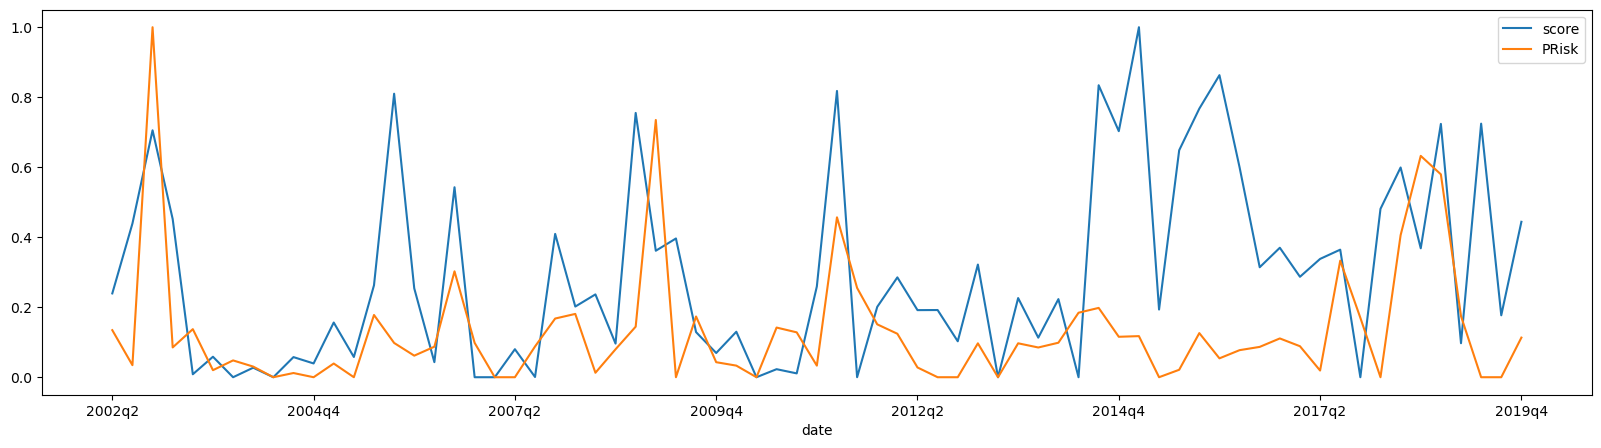

In [76]:
print("Correlation:", compare['score'].corr(compare['PRisk']))
compare.plot(figsize=(20,5))

Correlation: 0.1784710721581908


<Axes: xlabel='date'>

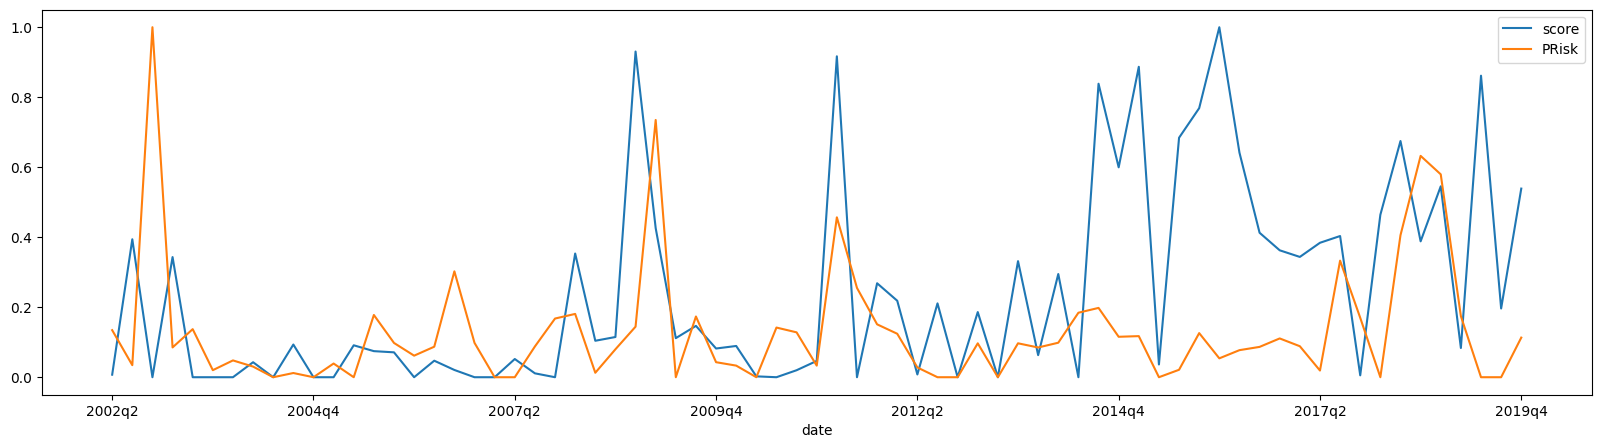

In [79]:
print("Correlation:", compare['score'].corr(compare['PRisk']))
compare.plot(figsize=(20,5))